- Assume that each person has a limit order distribution given by a N(a, b) for selling and buying

   - N = number of actors
   - Bid = B_mean, B_std, equals to the demand on the market (orders to purchase asset)
   - Ask = A_mean, A_std, equals to the supply on the market (orders to sell asset)

- The orders are inserted in a queue and matched

# Imports

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import research_amp.lob.lob_lib as ralololi

# Generate the data

In [ ]:
n_samples = 10
bid_asks_raw = ralololi.get_data(n_samples)
#
display(bid_asks_raw)
#
bid_asks_raw.plot.hist()

# Convert raw orders data into `supply-demand` state

In [ ]:
supply_demand = ralololi.get_supply_demand_curve(bid_asks_raw)
#
display(supply_demand.head(3))
#
supply_demand.plot()

# Find the equilibrium price and quantity

In [ ]:
eq_price, eq_quantity = ralololi.find_equilibrium(supply_demand)

# Check the supply-demand imbalances

In [ ]:
excess = supply_demand["supply"] - supply_demand["demand"]
excess.plot()
zero_crossings_idx = np.where(np.diff(np.sign(excess)) == 2)[0]
print(zero_crossings_idx)
excess.iloc[zero_crossings_idx[0] : zero_crossings_idx[0] + 2]

# MC simulation for equilibrium

In [ ]:
eq_df = pd.DataFrame()
for i in range(1, 500):
    ba_raw = ralololi.get_data(n_samples)
    sd = ralololi.get_supply_demand_curve(ba_raw)
    eq_p, eq_q = ralololi.find_equilibrium(sd, print_graph=False)
    eq_df.loc[i, "eq_price"] = eq_p
    eq_df.loc[i, "eq_quantity"] = eq_q

In [ ]:
eq_df["eq_price"].hist(bins=30)

In [ ]:
eq_df["eq_quantity"].hist(bins=20)

# Calculate the surplus

The total surplus is equal to `consumer surplus` + `producer surplus`:

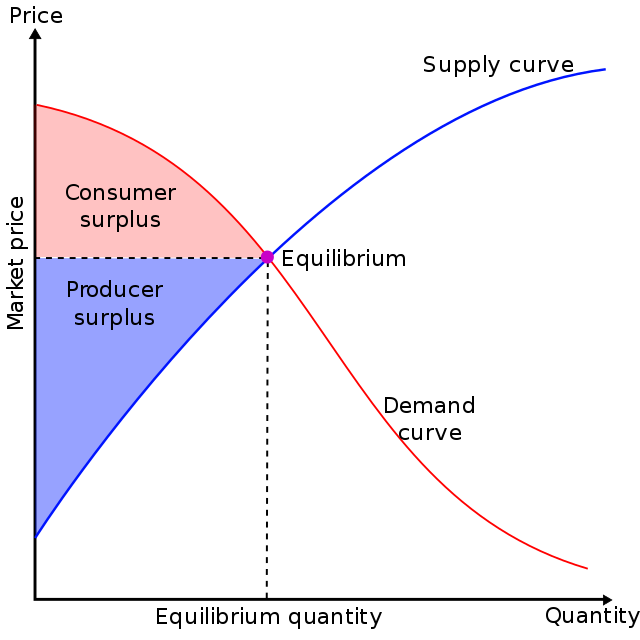

If we go back to our case, e.g., consumer surplus will be the following area:
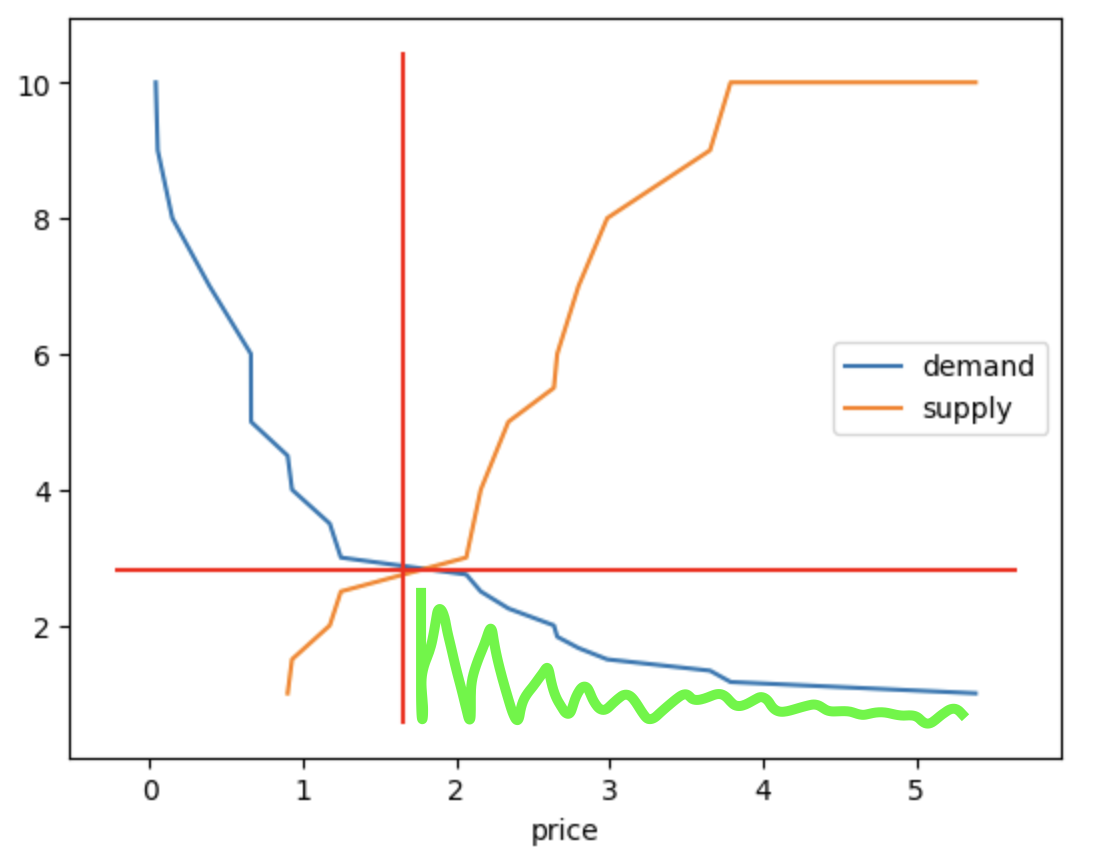

## Consumer surplus

In [ ]:
# The calculations in this case will be the following.
cons_surplus = supply_demand.copy()
# Isolate the consumer surplus part.
cons_surplus = cons_surplus[cons_surplus.index > eq_price]["demand"]
cons_surplus = cons_surplus.reset_index().set_index("demand")
cons_surplus = cons_surplus.sort_index()
cons_surplus = cons_surplus[cons_surplus.index.notnull()]
cons_surplus.plot()

In [ ]:
# The area below the line equals to consumer surplus.
cons_surplus_value = np.trapz(y=cons_surplus["price"], x=cons_surplus.index)
cons_surplus_value

## Producer surplus

In [ ]:
# The same but with producer surplus.
prod_surplus = supply_demand.copy()
# Isolate the producer surplus part.
prod_surplus = prod_surplus[prod_surplus.index < eq_price]["supply"]
prod_surplus = prod_surplus.reset_index().set_index("supply")
prod_surplus = prod_surplus.sort_index()
prod_surplus = prod_surplus[prod_surplus.index.notnull()]
prod_surplus.plot()

In [ ]:
# The area above the line is producer surplus.
# In this case we first need to find the square of the rectangle
# and subtract the square below the line.
ps_i = prod_surplus.index
ps_pr = prod_surplus["price"]
square_prod = (ps_i.max() - ps_i.min()) * ps_pr.max()
down_square_prod = np.trapz(y=ps_pr, x=ps_i)
prod_surplus_value = square_prod - down_square_prod
prod_surplus_value

## Total surplus

In [ ]:
total_surplus = prod_surplus_value + cons_surplus_value
total_surplus

# PDF of economic surplus

In [ ]:
# Create messy function for calculating economic surplus.
def calculate_economic_surplus(df, eq_price):
    # Consumer surplus.
    cons_surplus = df.copy()
    cons_surplus = cons_surplus[cons_surplus.index > eq_price]["demand"]
    cons_surplus = cons_surplus.reset_index().set_index("demand")
    cons_surplus = cons_surplus.sort_index()
    cons_surplus = cons_surplus[cons_surplus.index.notnull()]
    cons_surplus_value = np.trapz(y=cons_surplus["price"], x=cons_surplus.index)
    # Producer surplus.
    prod_surplus = df.copy()
    prod_surplus = prod_surplus[prod_surplus.index < eq_price]["supply"]
    prod_surplus = prod_surplus.reset_index().set_index("supply")
    prod_surplus = prod_surplus.sort_index()
    prod_surplus = prod_surplus[prod_surplus.index.notnull()]
    ps_i = prod_surplus.index
    ps_pr = prod_surplus["price"]
    square_prod = (ps_i.max() - ps_i.min()) * ps_pr.max()
    down_square_prod = np.trapz(y=ps_pr, x=ps_i)
    prod_surplus_value = square_prod - down_square_prod
    #
    total_surplus = prod_surplus_value + cons_surplus_value
    return total_surplus

In [ ]:
# MC simulation for obtaining economic surplus.
ec_surplus_df = pd.DataFrame()
for i in range(1, 500):
    ba_raw = ralololi.get_data(n_samples)
    sd = ralololi.get_supply_demand_curve(ba_raw)
    eq_p, _ = ralololi.find_equilibrium(sd, print_graph=False)
    total_surplus = calculate_economic_surplus(sd, eq_p)
    ec_surplus_df.loc[i, "econ_surplus"] = total_surplus

In [ ]:
ec_surplus_df.hist(bins=20)